In [80]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [81]:
import os
import numpy as np
import xarray as xr

import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import matplotlib.colors as colors
import cmocean

import xpersist as xp
cache_dir = '/glade/p/cgd/oce/projects/cesm2-marbl/xpersist_cache/3d_fields'
if (os.path.isdir(cache_dir)):
    xp.settings['cache_dir'] = cache_dir
os.makedirs(cache_dir, exist_ok=True)

os.environ['CESMDATAROOT'] = '/glade/scratch/mclong/inputdata'
import pop_tools


import climo_utils as cu
import utils
import glodap 

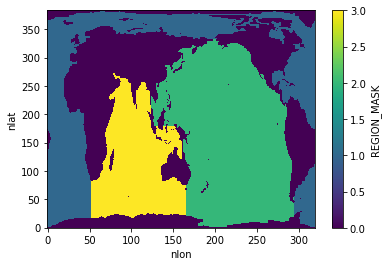

In [82]:
mask3d = utils.get_pop_region_mask_za(mask_type='3D')
basins = mask3d.region.rename({'region': 'basins'})
mask2d = utils.get_pop_region_mask_za(mask_type='2D')
mask2d.plot()

In [83]:
µmolkg_to_mmolm3 = 1026. * 1e-3 # µmol/kg --> mmol/m^3
µmolkg_to_mmolm3

1.026

In [84]:
ds = glodap.open_glodap('GLODAPv1')
ds

<xarray.Dataset>
Dimensions:      (depth: 33, depth_edges: 34, lat: 180, lon: 360)
Coordinates:
  * depth        (depth) float64 0.0 10.0 20.0 30.0 ... 4.5e+03 5e+03 5.5e+03
  * lat          (lat) float64 -89.5 -88.5 -87.5 -86.5 ... 86.5 87.5 88.5 89.5
  * lon          (lon) float64 -179.5 -178.5 -177.5 -176.5 ... 177.5 178.5 179.5
  * depth_edges  (depth_edges) float64 0.0 5.0 15.0 ... 5.25e+03 6.5e+03
Data variables:
    ALK          (depth, lat, lon) float64 nan nan nan nan ... nan nan nan nan
    Cant         (depth, lat, lon) float64 nan nan nan nan ... nan nan nan nan
    BkgC14       (depth, lat, lon) float64 nan nan nan nan ... nan nan nan nan
    Del14C       (depth, lat, lon) float64 nan nan nan nan ... nan nan nan nan
    CFC11        (depth, lat, lon) float64 nan nan nan nan ... nan nan nan nan
    CFC12        (depth, lat, lon) float64 nan nan nan nan ... nan nan nan nan
    DIC          (depth, lat, lon) float64 nan nan nan nan ... nan nan nan nan
    pCFC11       (depth, lat, lon) float64 nan nan nan nan ... nan nan nan nan
    pCFC12       (depth, lat, lon) float64 nan nan nan nan ... nan nan nan nan

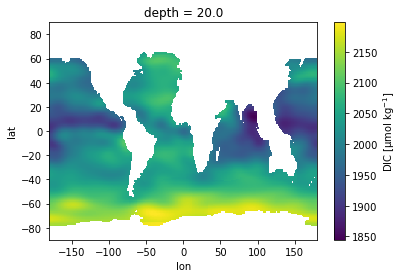

In [85]:
ds.DIC.isel(depth=2).plot()

In [86]:
dsp = glodap.open_glodap_pop_grid('GLODAPv1')
dsp

exists: /glade/work/mclong/adhoc-regridding/POP_gx1v7.nc
exists: /glade/work/mclong/adhoc-regridding/latlon_glodapv1.nc
source grid dims: (180, 360)
destination grid dims: (384, 320)


<xarray.Dataset>
Dimensions:  (nlat: 384, nlon: 320, z_t: 60)
Coordinates:
    TLONG    (nlat, nlon) float64 320.6 321.7 322.8 323.9 ... 318.9 319.4 319.8
    TLAT     (nlat, nlon) float64 -79.22 -79.22 -79.22 ... 72.2 72.19 72.19
    TAREA    (nlat, nlon) float64 1.125e+13 1.125e+13 ... 7.431e+12 7.432e+12
  * z_t      (z_t) float64 500.0 1.5e+03 2.5e+03 ... 5.125e+05 5.375e+05
    dz       (z_t) float64 1e+03 1e+03 1e+03 1e+03 ... 2.499e+04 2.5e+04 2.5e+04
    KMT      (nlat, nlon) int32 0 0 0 0 0 0 0 0 0 0 0 ... 0 0 0 0 0 0 0 0 0 0 0
Dimensions without coordinates: nlat, nlon
Data variables:
    ALK      (z_t, nlat, nlon) float64 nan nan nan nan nan ... nan nan nan nan
    Cant     (z_t, nlat, nlon) float64 nan nan nan nan nan ... nan nan nan nan
    BkgC14   (z_t, nlat, nlon) float64 nan nan nan nan nan ... nan nan nan nan
    Del14C   (z_t, nlat, nlon) float64 nan nan nan nan nan ... nan nan nan nan
    CFC11    (z_t, nlat, nlon) float64 nan nan nan nan nan ... nan nan nan nan
    CFC12    (z_t, nlat, nlon) float64 nan nan nan nan nan ... nan nan nan nan
    DIC      (z_t, nlat, nlon) float64 nan nan nan nan nan ... nan nan nan nan
    pCFC11   (z_t, nlat, nlon) float64 nan nan nan nan nan ... nan nan nan nan
    pCFC12   (z_t, nlat, nlon) float64 nan nan nan nan nan ... nan nan nan nan
Attributes:
    lateral_dims:       [384, 320]
    vertical_dims:      60
    vert_grid_file:     gx1v7_vert_grid
    horiz_grid_fname:   inputdata/ocn/pop/gx1v7/grid/horiz_grid_20010402.ieeer8
    topography_fname:   inputdata/ocn/pop/gx1v7/grid/topography_20161215.ieeei4
    region_mask_fname:  inputdata/ocn/pop/gx1v7/grid/region_mask_20151008.ieeei4
    type:               dipole
    title:              POP_gx1v7 grid

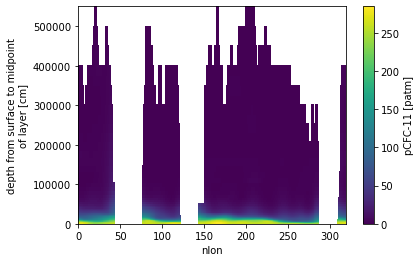

In [103]:
dsp.pCFC11.isel(nlat=200).plot()

(384, 320)


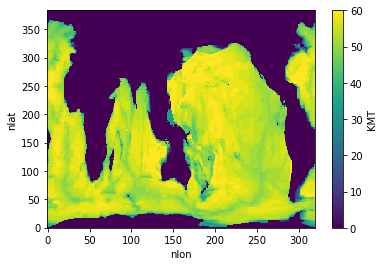

In [126]:
def compute_kmt(da):
    nk = len(da.z_t)
    
    KMT = np.zeros(da.shape[-2:]).astype(int)
    print(KMT.shape)
    #-- where surface is missing, KMT = 0, else full depth
    KMT = np.where(np.isnan(da.data[0, :, :]), 0, nk)

    #   where level k is missing: KMT = k, i.e. the level above in 1-based indexing
    for k in range(1, nk):
        KMT = np.where(np.isnan(da.data[k, :, :]) & (KMT > k), k, KMT)

    return xr.DataArray(KMT, dims=('nlat', 'nlon'), name='KMT')

kmt = compute_kmt(dsp.pCFC11)
kmt.plot()

In [116]:
da = dsp.pCFC11
nk = len(da.z_t)


<xarray.DataArray (nlat: 320)>
array([[ 0,  0,  0, ...,  0,  0,  0],
       [ 0,  0,  0, ...,  0,  0,  0],
       [30, 30, 30, ...,  0,  0,  0],
       ...,
       [ 0,  0,  0, ...,  0,  0,  0],
       [ 0,  0,  0, ...,  0,  0,  0],
       [ 0,  0,  0, ...,  0,  0,  0]])
Dimensions without coordinates: nlat, nlat

In [135]:
ds = glodap.open_glodap_pop_grid(product_name)[['pCFC11']]
ds

exists: /glade/work/mclong/adhoc-regridding/POP_gx1v7.nc
exists: /glade/work/mclong/adhoc-regridding/latlon_glodapv1.nc
source grid dims: (180, 360)
destination grid dims: (384, 320)


<xarray.Dataset>
Dimensions:  (nlat: 384, nlon: 320, z_t: 60)
Coordinates:
    TLONG    (nlat, nlon) float64 320.6 321.7 322.8 323.9 ... 318.9 319.4 319.8
    TLAT     (nlat, nlon) float64 -79.22 -79.22 -79.22 ... 72.2 72.19 72.19
    TAREA    (nlat, nlon) float64 1.125e+13 1.125e+13 ... 7.431e+12 7.432e+12
  * z_t      (z_t) float64 500.0 1.5e+03 2.5e+03 ... 5.125e+05 5.375e+05
    dz       (z_t) float64 1e+03 1e+03 1e+03 1e+03 ... 2.499e+04 2.5e+04 2.5e+04
    KMT      (nlat, nlon) int32 0 0 0 0 0 0 0 0 0 0 0 ... 0 0 0 0 0 0 0 0 0 0 0
Dimensions without coordinates: nlat, nlon
Data variables:
    pCFC11   (z_t, nlat, nlon) float64 nan nan nan nan nan ... nan nan nan nan
Attributes:
    lateral_dims:       [384, 320]
    vertical_dims:      60
    vert_grid_file:     gx1v7_vert_grid
    horiz_grid_fname:   inputdata/ocn/pop/gx1v7/grid/horiz_grid_20010402.ieeer8
    topography_fname:   inputdata/ocn/pop/gx1v7/grid/topography_20161215.ieeei4
    region_mask_fname:  inputdata/ocn/pop/gx1v7/grid/region_mask_20151008.ieeei4
    type:               dipole
    title:              POP_gx1v7 grid

In [136]:
ds_za = utils.zonal_mean_via_fortran(
    ds, 
    var='pCFC11', #','.join(fields_list), 
    grid='POP_gx1v7', 
    region_mask=mask2d,
    replace_kmt=True,
)
ds_za

(384, 320)
za ran successfully, writing netcdf output


<xarray.Dataset>
Dimensions:      (basins: 4, lat_t: 394, lat_t_edges: 395, z_t: 60)
Coordinates:
  * lat_t        (lat_t) float32 -79.22 -78.69 -78.15 ... 88.84 89.37 89.9
  * lat_t_edges  (lat_t_edges) float32 -79.49 -78.95 -78.42 ... 89.1 89.64 90.0
  * z_t          (z_t) float64 500.0 1.5e+03 2.5e+03 ... 5.125e+05 5.375e+05
Dimensions without coordinates: basins
Data variables:
    pCFC11       (basins, z_t, lat_t) float64 ...

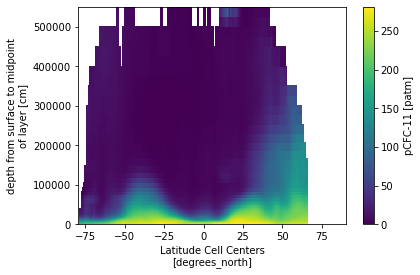

In [138]:
ds_za.pCFC11.isel(basins=1).plot()

In [139]:
fields_from = {
    'GLODAPv1': ['pCFC11', 'pCFC12', 'Del14C'],
    'GLODAPv2.2016b_MappedClimatologies': ['Cant', 'ALK'],
}

ds_list = []
for product_name, fields_list in fields_from.items():
    ds = glodap.open_glodap_pop_grid(product_name)[fields_list]
    ds_list_i = []
    for v in fields_list:
        ds_list_i.append(
            utils.zonal_mean_via_fortran(
                ds, var=v, 
                grid='POP_gx1v7', 
                region_mask=mask2d,
                replace_kmt=True,
            )
        )
        
    ds_list.append(xr.merge(ds_list_i))

ds_za = xr.merge(ds_list)

with xr.set_options(keep_attrs=True):
    for v in ['Cant', 'ALK']:
        ds_za[v] = ds_za[v] * µmolkg_to_mmolm3
        ds_za[v].attrs['units'] = 'mmol m$^{-3}$'

ds_za = ds_za.rename({k: f'{k}_obs' for k in ds_za.data_vars})
ds_za['basins'] = basins
ds_za

exists: /glade/work/mclong/adhoc-regridding/POP_gx1v7.nc
exists: /glade/work/mclong/adhoc-regridding/latlon_glodapv1.nc
source grid dims: (180, 360)
destination grid dims: (384, 320)
(384, 320)
za ran successfully, writing netcdf output
(384, 320)
za ran successfully, writing netcdf output
(384, 320)
za ran successfully, writing netcdf output
exists: /glade/work/mclong/adhoc-regridding/POP_gx1v7.nc
exists: /glade/work/mclong/adhoc-regridding/latlon_glodapv2.nc
source grid dims: (180, 360)
destination grid dims: (384, 320)
(384, 320)
za ran successfully, writing netcdf output
(384, 320)
za ran successfully, writing netcdf output


<xarray.Dataset>
Dimensions:      (basins: 4, lat_t: 394, lat_t_edges: 395, z_t: 60)
Coordinates:
  * basins       (basins) <U14 'Global' 'Atlantic Ocean' ... 'Indian Ocean'
  * lat_t        (lat_t) float32 -79.22 -78.69 -78.15 ... 88.84 89.37 89.9
  * lat_t_edges  (lat_t_edges) float32 -79.49 -78.95 -78.42 ... 89.1 89.64 90.0
  * z_t          (z_t) float64 500.0 1.5e+03 2.5e+03 ... 5.125e+05 5.375e+05
Data variables:
    pCFC11_obs   (basins, z_t, lat_t) float64 ...
    pCFC12_obs   (basins, z_t, lat_t) float64 ...
    Del14C_obs   (basins, z_t, lat_t) float64 ...
    Cant_obs     (basins, z_t, lat_t) float64 nan nan 34.09 ... nan nan nan
    ALK_obs      (basins, z_t, lat_t) float64 nan nan 2.382e+03 ... nan nan nan

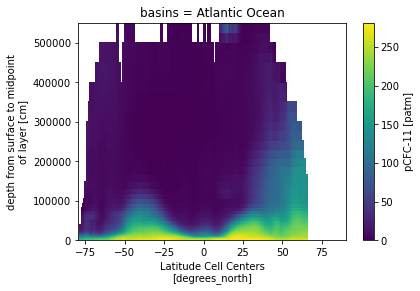

In [140]:
ds_za.pCFC11_obs.isel(basins=1).plot()

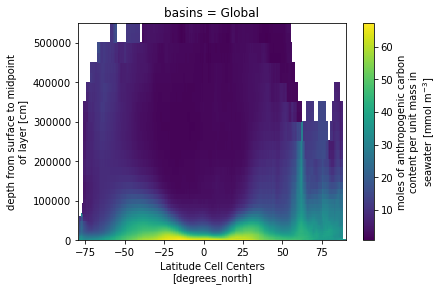

In [141]:
ds_za.Cant_obs.isel(basins=0).plot()

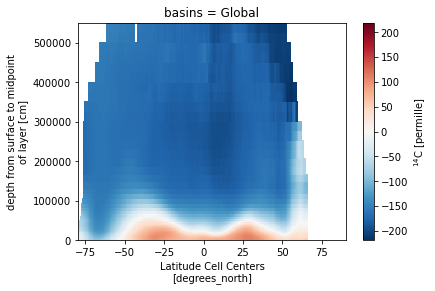

In [142]:
ds_za.Del14C_obs.isel(basins=0).plot()

In [94]:
cluster, client = utils.get_ClusterClient()
cluster.scale(12) #adapt(minimum_jobs=0, maximum_jobs=24)
client

/glade/work/mclong/miniconda3/envs/co2-hole/lib/python3.7/site-packages/distributed/dashboard/core.py:79: UserWarning: 
Port 8787 is already in use. 
Perhaps you already have a cluster running?
Hosting the diagnostics dashboard on a random port instead.
  warnings.warn("\n" + msg)


Client Scheduler: tcp://10.12.206.63:44595 Dashboard: https://jupyterhub.hpc.ucar.edu/stable/user/mclong/proxy/35063/status,Cluster Workers: 0 Cores: 0 Memory: 0 B


In [95]:
time_slice_glodapv2 = slice('2002-01-15', '2003-01-15')
time_slice_glodapv1 = slice('1990-01-15', '2001-01-15')

cesm_fields = dict(
    Cant=time_slice_glodapv2,
    ALK=time_slice_glodapv2,    
    pCFC11=time_slice_glodapv1,
    pCFC12=time_slice_glodapv1,    
    Del14C=time_slice_glodapv1,    
)

ds_cesm = {}
for variable, time_slice in cesm_fields.items():   
    xp_func = xp.persist_ds(cu.read_CESM_var, name=f'{variable}', trust_cache=True)    
    ds_cesm[variable] = xp_func(
        time_slice, 
        variable, 
        mean_dims=['member_id', 'time'], 
    )

assuming cache is correct
reading cached file: /glade/p/cgd/oce/projects/cesm2-marbl/xpersist_cache/3d_fields/Cant.nc
assuming cache is correct
reading cached file: /glade/p/cgd/oce/projects/cesm2-marbl/xpersist_cache/3d_fields/ALK.nc
assuming cache is correct
reading cached file: /glade/p/cgd/oce/projects/cesm2-marbl/xpersist_cache/3d_fields/pCFC11.nc
assuming cache is correct
reading cached file: /glade/p/cgd/oce/projects/cesm2-marbl/xpersist_cache/3d_fields/pCFC12.nc
assuming cache is correct
reading cached file: /glade/p/cgd/oce/projects/cesm2-marbl/xpersist_cache/3d_fields/Del14C.nc


In [96]:
client.close()
cluster.close()
del client
del cluster

In [146]:
ds_tmp = xr.merge([ds for ds in ds_cesm.values()])
ds_tmp = utils.zonal_mean_via_fortran(ds_tmp, 
                                      ','.join(ds_cesm.keys()), grid='POP_gx1v7', 
                                      region_mask=mask2d)
ds_tmp['z_t'] = ds_za.z_t
ds_za = xr.merge((ds_tmp, ds_za))

for v in ['pCFC11', 'pCFC12', 'Cant', 'Del14C']:
    ds_za[f'{v}_bias'] = ds_za[v] - ds_za[f'{v}_obs']
ds_za

za ran successfully, writing netcdf output


<xarray.Dataset>
Dimensions:      (basins: 4, lat_t: 394, lat_t_edges: 395, z_t: 60)
Coordinates:
  * basins       (basins) object 'Global' 'Atlantic Ocean' ... 'Indian Ocean'
  * lat_t        (lat_t) float32 -79.22 -78.69 -78.15 ... 88.84 89.37 89.9
  * lat_t_edges  (lat_t_edges) float32 -79.49 -78.95 -78.42 ... 89.1 89.64 90.0
  * z_t          (z_t) float64 500.0 1.5e+03 2.5e+03 ... 5.125e+05 5.375e+05
Data variables:
    Cant         (basins, z_t, lat_t) float32 ...
    ALK          (basins, z_t, lat_t) float32 ...
    pCFC11       (basins, z_t, lat_t) float32 ...
    pCFC12       (basins, z_t, lat_t) float32 ...
    Del14C       (basins, z_t, lat_t) float32 ...
    pCFC11_obs   (basins, z_t, lat_t) float64 nan nan 215.6 ... nan nan nan
    pCFC12_obs   (basins, z_t, lat_t) float64 nan nan 415.1 ... nan nan nan
    Del14C_obs   (basins, z_t, lat_t) float64 nan nan -23.11 ... nan nan nan
    Cant_obs     (basins, z_t, lat_t) float64 nan nan 34.09 ... nan nan nan
    ALK_obs      (basins, z_t, lat_t) float64 nan nan 2.382e+03 ... nan nan nan
    pCFC11_bias  (basins, z_t, lat_t) float64 nan nan -11.27 ... nan nan nan
    pCFC12_bias  (basins, z_t, lat_t) float64 nan nan -16.48 ... nan nan nan
    Cant_bias    (basins, z_t, lat_t) float64 nan nan -3.923 ... nan nan nan
    Del14C_bias  (basins, z_t, lat_t) float64 nan nan -16.61 ... nan nan nan

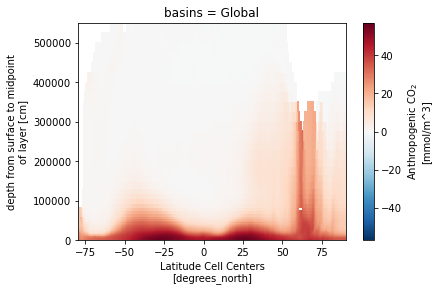

In [147]:
ds_za.Cant.isel(basins=0).plot()

In [148]:
ds_zonal_mean = ds_za

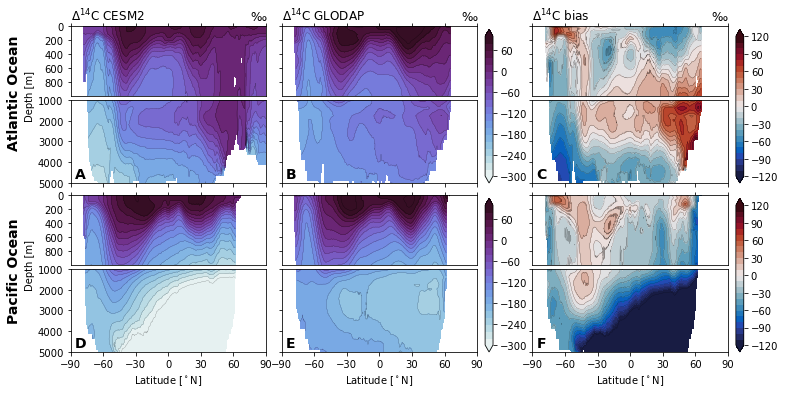

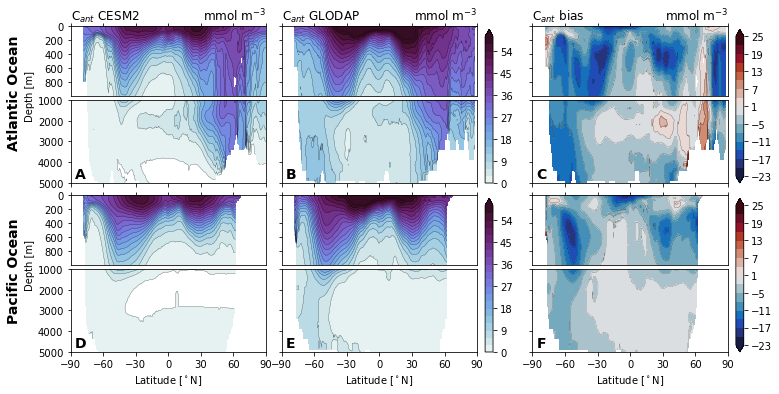

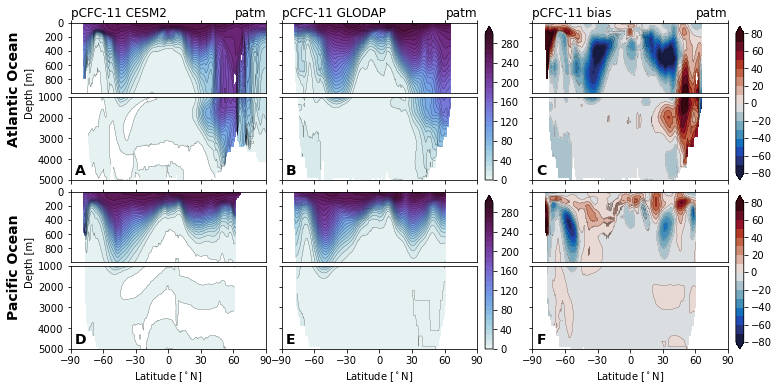

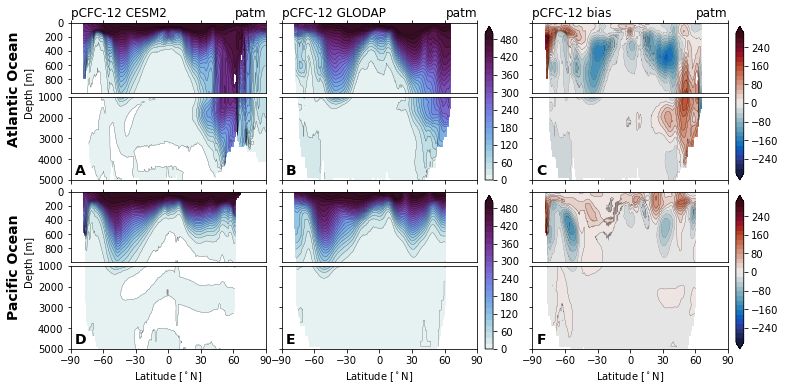

In [156]:
import plot

levels = dict(
    Cant=np.arange(0, 63, 3),
    pCFC11=np.arange(0, 310, 10),
    pCFC12=np.arange(0, 520, 20),
    Del14C=np.arange(-300, 120, 20),    
    ALK=np.arange(1800, 2600, 200),        
)

    
levels_bias = dict(
    Cant=np.arange(-23, 26, 3),
    pCFC11=np.arange(-80, 90, 10),    
    pCFC12=np.arange(-300, 320, 20),        
    Del14C=np.arange(-120, 130, 10),        
)  

for field in ['Del14C', 'Cant', 'pCFC11', 'pCFC12',]:
    plot.za_obs_comparison(
        ds_za, 
        field=field, 
        levels=levels[field], 
        levels_bias=levels_bias[field],
    )
    utils.savefig(f'za-obs-comparison-{field}.pdf')